# Big data mart sales

### Description

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.
Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

In [86]:
#Importing Necessary Libraries
#Matplot and seaborn for making graphs
%matplotlib notebook
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
import featuretools as ft
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [87]:
df_train=pd.read_csv("C:/Users/HP/anaconda3/DataScience/DataTrainedProjects/BigMart_train.csv")
df_test=pd.read_csv("C:/Users/HP/anaconda3/DataScience/DataTrainedProjects/BigMart_test.csv")

In [88]:
df_train.shape
df_test.shape

(8523, 12)

(5681, 11)

In [89]:
def concat(X,Y):
    df=pd.concat([X,Y],ignore_index=True)
    return df

In [90]:
df=concat(df_train,df_test)
df.shape

(14204, 12)

In [91]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [92]:
Cat_var=['Item_Fat_content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']

In [93]:
#Checks number of null values for all the variables
df.isnull().sum()
#Item_Weight has 2439 null values 
#Outlet Size has 4016 null valuesdf.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
dtype: int64

In [94]:
#Checks the number of unique entries correspnding to each variable
df.nunique()

Item_Identifier               1559
Item_Weight                    415
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      3
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3493
dtype: int64

In [95]:
#defining a function:
#frequency of unique entries in each columns with their names

def frequency_of_each_item(X,Y):
    for i in Y:
        print("frequency of each category for",i)
        print(X[i].value_counts())

In [97]:
#frequency of unique entries in each columns with their names
category=['Item_Fat_Content','Item_Type','Outlet_Location_Type','Outlet_Size','Outlet_Type']
frequency_of_each_item(df,category)

frequency of each category for Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
frequency of each category for Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
frequency of each category for Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64
frequency of each category for Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
frequency of each category

In [101]:
#filling Null values in Outlet size to mode
Outlet_Size_mode=df.pivot_table(values='Outlet_Size', index='Outlet_Type',aggfunc=(lambda x: stats.mode(x)[0]),dropna=True)
print(Outlet_Size_mode)
bool=df['Outlet_Type'].isnull()
df['Outlet_Size'][bool]=df['Outlet_Type'][bool].apply(lambda x : Outlet_Size_mode.loc[x]).values
sum(df['Outlet_Size'].isnull())

                  Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium


0

In [102]:
# Correcting the mis-written datas
df['Item_Fat_Content'].replace(to_replace =['low fat','reg','LF'], 
                               value =['Low Fat','Regular','Low Fat'],inplace=True)
df['Item_Fat_Content'].value_counts()
df.head()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Small,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Small,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,Small,Tier 3,Supermarket Type1,994.7052


In [103]:
#filling Null values in the Item Weight to mean value
item_weight_mean=df.pivot_table(values='Item_Weight', index='Item_Identifier',aggfunc=[np.mean],dropna=True)
print(item_weight_mean)
df['Item_Weight']=df['Item_Identifier'].apply(lambda x :item_weight_mean.loc[x]).values
sum(df['Item_Weight'].isnull())

                       mean
                Item_Weight
Item_Identifier            
DRA12                11.600
DRA24                19.350
DRA59                 8.270
DRB01                 7.390
DRB13                 6.115
...                     ...
NCZ30                 6.590
NCZ41                19.850
NCZ42                10.500
NCZ53                 9.600
NCZ54                14.650

[1559 rows x 1 columns]


0

In [104]:
#Reducing food category to only 3 types with the help of the first 2 alphabets of the Item_Identifier column

df['Item_Type_combined']=df['Item_Identifier'].apply(lambda x : x[0:2])
df['Item_Type_combined'].replace(to_replace =['FD','DR','NC'], 
                 value =['Food','Drinks','Non_consumable'],inplace=True)
 #dropping the redundant column
df=df.drop(columns=['Item_Type'])     
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,1999,Small,Tier 1,Supermarket Type1,3735.1380,Food
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,1999,Small,Tier 1,Supermarket Type1,2097.2700,Food
3,FDX07,19.20,Regular,0.000000,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food
4,NCD19,8.93,Low Fat,0.000000,53.8614,OUT013,1987,Small,Tier 3,Supermarket Type1,994.7052,Non_consumable


In [105]:
#Calculating number of Item_fat_contents that are also non_consumable

bool=df['Item_Type_combined']=='Non_consumable'
df['Item_Fat_Content'][bool]='Non_edible'
df['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non_edible    2686
Name: Item_Fat_Content, dtype: int64

In [106]:
#Using feature Engineering and adding new column
df['yearsold']=2013-df['Outlet_Establishment_Year']
df=df.drop(columns=['Outlet_Establishment_Year'])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,yearsold
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,Small,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,Small,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.000000,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non_edible,0.000000,53.8614,OUT013,Small,Tier 3,Supermarket Type1,994.7052,Non_consumable,26


In [107]:
# Converting all the zero values to mean in the visibility column
Item_Visibility_mean=df.pivot_table(index='Item_Identifier',values='Item_Visibility',aggfunc=[np.mean])
print(Item_Visibility_mean)
bool4=df['Item_Visibility']==0
df['Item_Visibility'][bool4]=df['Item_Identifier'][bool4].apply(lambda x:Item_Visibility_mean.loc[x] ).values
df.head()

                           mean
                Item_Visibility
Item_Identifier                
DRA12                  0.034938
DRA24                  0.045646
DRA59                  0.133384
DRB01                  0.079736
DRB13                  0.006799
...                         ...
NCZ30                  0.027302
NCZ41                  0.056396
NCZ42                  0.011015
NCZ53                  0.026330
NCZ54                  0.081345

[1559 rows x 1 columns]


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,yearsold
0,FDA15,9.30,Low Fat,0.016047,249.8092,OUT049,Small,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,141.6180,OUT049,Small,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.040627,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,Non_edible,0.093093,53.8614,OUT013,Small,Tier 3,Supermarket Type1,994.7052,Non_consumable,26


In [108]:
#Checks for correlation between different numerical columns
df.corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,yearsold
Item_Weight,1.000000,-0.018976,0.035751,0.013261,-0.000247
Item_Visibility,-0.018976,1.000000,-0.009766,-0.129396,0.083223
Item_MRP,0.035751,-0.009766,1.000000,0.567574,-0.000141
Item_Outlet_Sales,0.013261,-0.129396,0.567574,1.000000,0.049135
yearsold,-0.000247,0.083223,-0.000141,0.049135,1.000000


In [109]:
# Identifying outliers and fixing them

<AxesSubplot:>

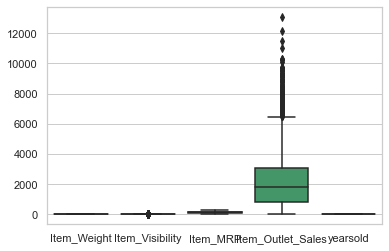

In [110]:

sns.boxplot(data=df,palette='BuGn')
plt.show()

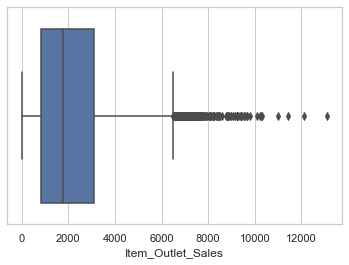

In [111]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=df["Item_Outlet_Sales"])

In [112]:
#As we know only Item_Outlet_Sales have outliers we can fix them but fixing them will increase our RMSE score 
#to a large extent

### Plotting Graphs for more Analysis

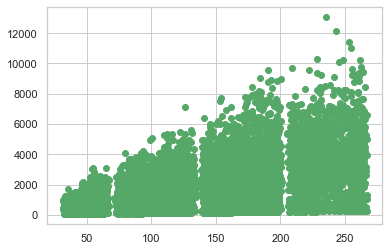

In [113]:
plt.scatter(df.Item_MRP,df.Item_Outlet_Sales,c='g')
plt.show()

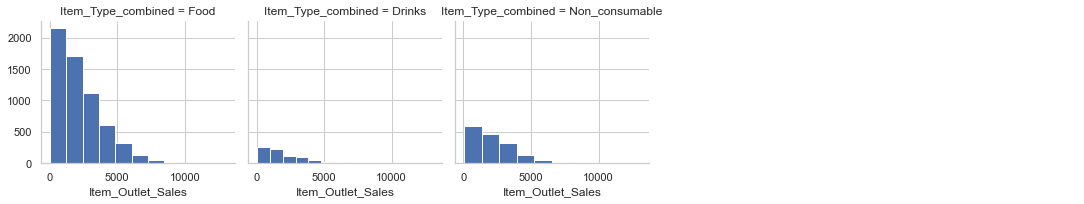

In [114]:
sns.FacetGrid(df, col='Item_Type_combined', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();


In [115]:
# Maximum contribution to outlet sales is from Items that are food type and least is from drinks

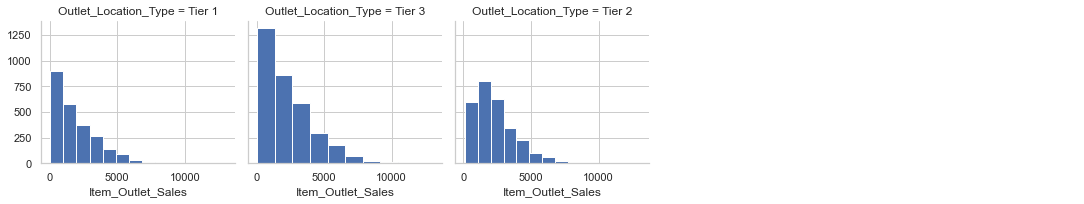

In [116]:
sns.FacetGrid(df, col='Outlet_Location_Type', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();

In [117]:
#Tier3 type of outlet location provides for the maximum sales and other two provides the 
# least sales

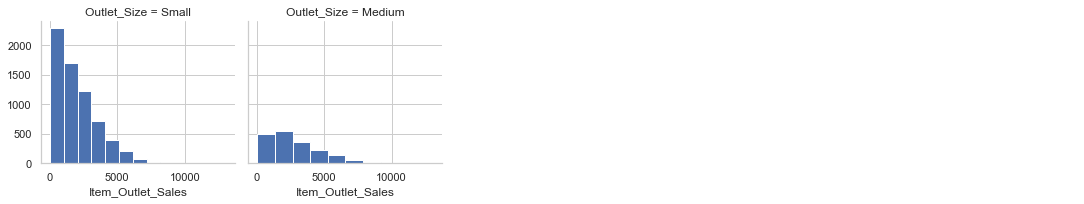

In [118]:
sns.FacetGrid(df, col='Outlet_Size', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Small sized Outlets are providing the maximum sales whereas medium sized outlets 
# are contributing the least

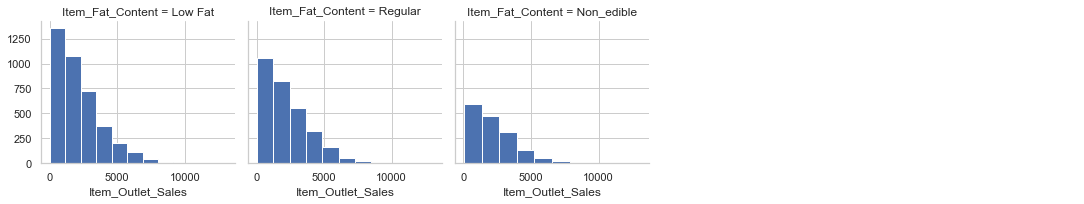

In [119]:
sns.FacetGrid(df, col='Item_Fat_Content', size=3, col_wrap=5) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
# people are prefering items with lowest fat content the most 

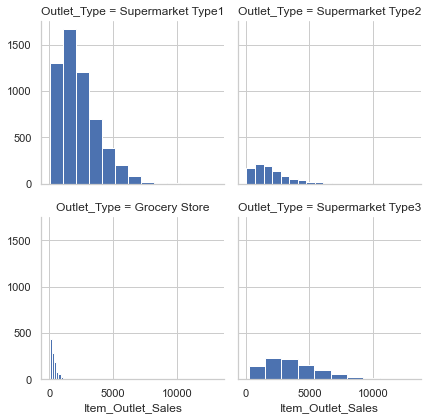

In [120]:
sns.FacetGrid(df, col='Outlet_Type', size=3, col_wrap=2) \
    .map(plt.hist, 'Item_Outlet_Sales') \
    .add_legend();
#Maximum of the high sales margin is from Supermarket Type1
#Grocery store has the least sales

In [128]:
df.skew()

Item_Weight          0.100417
Item_Visibility      1.256408
Item_MRP             0.130728
Item_Outlet_Sales    1.177531
yearsold             0.396465
dtype: float64

In [135]:
#remove skewness using boxcox
from scipy.stats import boxcox

df['Item_Visibility']=boxcox(df['Item_Visibility'],0)
df['Item_Outlet_Sales']=boxcox(df['Item_Outlet_Sales'],0)

In [136]:
#Label Encoding all the columns with text entries and dropping Item_identifier  
le=LabelEncoder()
list=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Item_Type_combined',
      'Outlet_Size']
for i in list:
    le.fit(df[i])
    df[i]=le.transform(df[i])
df_new=df.drop(columns='Item_Identifier')
df_new= pd.get_dummies(df_new,columns=['Outlet_Identifier'])
df_new.head()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,-4.132215,249.8092,1,0,1,8.225540,1,14,0,0,0,0,0,0,0,0,0,1
1,5.92,2,-3.948780,48.2692,0,2,2,6.094524,0,4,0,0,0,1,0,0,0,0,0,0
2,17.50,0,-4.088756,141.6180,1,0,1,7.648392,1,14,0,0,0,0,0,0,0,0,0,1
3,19.20,2,-3.203334,182.0950,1,2,0,6.596300,1,15,1,0,0,0,0,0,0,0,0,0
4,8.93,1,-2.374151,53.8614,1,2,1,6.902446,2,26,0,1,0,0,0,0,0,0,0,0


In [137]:
df_new.shape

(14204, 20)

In [138]:
#Separating test and train set
df_new_train=df_new.iloc[:8523,:]
df_new_test=df_new.iloc[8523:,:]
df_new_test=df_new_test.drop(columns=['Item_Outlet_Sales'])

In [139]:
Y_train=df_new_train['Item_Outlet_Sales']
df_train_test=df_new_train.drop(columns=['Item_Outlet_Sales'])


In [140]:
!pip install xgboost

In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet 
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb


In [142]:
models = [('lr',LinearRegression()),('ridge',Ridge()),('rfr',RandomForestRegressor()),('etr',ExtraTreesRegressor()),
         ('br',BaggingRegressor()),('gbr',GradientBoostingRegressor()),('en',ElasticNet()),('mlp',MLPRegressor())]

In [143]:
#Making function for making best 2 models for further hyperparameter tuning
def basic_model_selection(x,y,cross_folds,model):
    scores=[]
    names = []
    for i,j in model:
        cv_scores = cross_val_score(j, x, y, cv=cross_folds,n_jobs=5)
        scores.append(cv_scores)
        names.append(i)
    for k in range(len(scores)):
        print(names[k],scores[k].mean())

In [144]:
basic_model_selection(df_train_test,Y_train,4,models)

lr 0.718487501596281
ridge 0.7184891588047886
rfr 0.7041194181739017
etr 0.6856257473188995
br 0.682338093203828
gbr 0.7362391135384948
en 0.26117634178521487
mlp 0.7278095241342035


In [145]:
#Average score for XGBoost matrix
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=df_train_test,label=Y_train)
# import XGBRegressor
xgb1 = XGBRegressor()
cv_score = cross_val_score(xgb1, df_train_test, Y_train, cv=4,n_jobs=5)
print(cv_score.mean())

0.7031232441583763


## Hyper parameter Tuning

In [146]:
def model_parameter_tuning(x,y,model,parameters,cross_folds):
    model_grid = GridSearchCV(model,
                        parameters,
                        cv = cross_folds,
                        n_jobs = 5,
                        verbose=True)
    model_grid.fit(x,y)
    y_predicted = model_grid.predict(x)
    print(model_grid.score)
    print(model_grid.best_params_)
    print("The RMSE score is",np.sqrt(np.mean((y-y_predicted)**2)))

#defining function for hyper parameter tuning and using RMSE as my metric
    

In [147]:
parameters_ridge={'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500],
                 'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
                 'random_state':[42,30,0],
                 } 
parameters_gbr={'loss':['ls','lad'],
               'learning_rate':[0.3],
               'n_estimators':[300],
               'min_samples_split':[3,4],
               'max_depth':[3,4],
               'min_samples_leaf':[3,4,2],
               'max_features':['auto','log2','sqrt']
              }

# Defining the useful parameters for parameter tuning
# to get the optimum output

In [148]:
model_parameter_tuning(df_train_test,Y_train,Ridge(),parameters_ridge,4)

Fitting 4 folds for each of 216 candidates, totalling 864 fits
<bound method BaseSearchCV.score of GridSearchCV(cv=4, estimator=Ridge(), n_jobs=5,
             param_grid={'alpha': [200, 230, 250, 265, 270, 275, 290, 300, 500],
                         'random_state': [42, 30, 0],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga', 'lbfgs']},
             verbose=True)>
{'alpha': 200, 'random_state': 42, 'solver': 'auto'}
The RMSE score is 0.5447191218947527


In [149]:
gbr=GradientBoostingRegressor()
model_parameter_tuning(df_train_test,Y_train,gbr,parameters_gbr,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
<bound method BaseSearchCV.score of GridSearchCV(cv=4, estimator=GradientBoostingRegressor(), n_jobs=5,
             param_grid={'learning_rate': [0.3], 'loss': ['ls', 'lad'],
                         'max_depth': [3, 4],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [3, 4, 2],
                         'min_samples_split': [3, 4], 'n_estimators': [300]},
             verbose=True)>
{'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 300}
The RMSE score is 0.5025541739946577


## Standardization of the model before training


In [150]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized=scaler.fit_transform(df_train_test)
column_names = df_train_test.columns
df_standardized = pd.DataFrame(data=standardized,columns=column_names)
df_standardized.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,-0.769246,-0.997813,-1.513077,1.747454,0.528895,-1.369334,-0.252658,-0.179795,-0.139541,-0.263920,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,2.857362
1,-1.496813,1.236942,-1.281232,-1.489023,-1.890735,1.091569,1.002972,-2.095286,-1.334103,-0.263920,-0.350395,-0.349128,2.860816,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973
2,0.995858,-0.997813,-1.458149,0.010040,0.528895,-1.369334,-0.252658,-0.179795,-0.139541,-0.263920,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,2.857362
3,1.361794,1.236942,-0.339057,0.660050,0.528895,1.091569,-1.508289,-0.179795,-0.020085,3.789031,-0.350395,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973
4,-0.848890,0.119565,0.708954,-1.399220,0.528895,1.091569,-0.252658,1.735696,1.293934,-0.263920,2.853918,-0.349128,-0.349551,-0.256985,-0.351028,-0.349973,-0.349762,-0.349973,-0.349973


In [151]:
basic_model_selection(df_standardized,Y_train,4,models)

lr 0.7180357639735553
ridge 0.7184878145882663
rfr 0.7040518279665899
etr 0.686225945375889
br 0.6827048069890862
gbr 0.7362292219345075
en 0.01155690385742203
mlp 0.7310423599367624


In [152]:
#Average score for XGBoost matrix
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=df_standardized,label=Y_train)
# import XGBRegressor
xgb1 = XGBRegressor()
cv_score = cross_val_score(xgb1, df_standardized, Y_train, cv=4,n_jobs=5)
print(cv_score.mean())

0.7031144505640776


In [153]:
model_parameter_tuning(df_standardized,Y_train,gbr,parameters_gbr,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
<bound method BaseSearchCV.score of GridSearchCV(cv=4, estimator=GradientBoostingRegressor(), n_jobs=5,
             param_grid={'learning_rate': [0.3], 'loss': ['ls', 'lad'],
                         'max_depth': [3, 4],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [3, 4, 2],
                         'min_samples_split': [3, 4], 'n_estimators': [300]},
             verbose=True)>
{'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
The RMSE score is 0.5071489139479137


## Using Robust Scalar

In [154]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

normalize = MinMaxScaler()
robust = RobustScaler(quantile_range = (0.1,0.8)) #range of inerquartile is one of the parameters
robust_stan = robust.fit_transform(df_train_test)
robust_stan_normalize = normalize.fit_transform(robust_stan)
# also normalized the dataset using MinMaxScaler i.e has bought the data set between (0,1)
df_robust_normalize = pd.DataFrame(robust_stan_normalize,columns=column_names)
df_robust_normalize.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_combined,yearsold,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,0.282525,0.0,0.332202,0.927507,1.0,0.0,0.333333,0.5,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.081274,1.0,0.372782,0.072068,0.0,1.0,0.666667,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.770765,0.0,0.341816,0.468288,1.0,0.0,0.333333,0.5,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.871986,1.0,0.537692,0.640093,1.0,1.0,0.000000,0.5,0.458333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.260494,0.5,0.721126,0.095805,1.0,1.0,0.333333,1.0,0.916667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
basic_model_selection(df_robust_normalize,Y_train,4,models)

lr 0.7184930383177877
ridge 0.7184895100079898
rfr 0.7049027240948424
etr 0.6844444656937023
br 0.6813739577379446
gbr 0.7362123988328628
en -0.000521550853658459
mlp 0.7366685533743185


In [156]:
cv_score = cross_val_score(gbr, df_robust_normalize, Y_train, cv=4,n_jobs=5)
print(cv_score.mean())

0.7362780459831713


In [157]:
model_parameter_tuning(df_robust_normalize,Y_train,gbr,parameters_gbr,4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
<bound method BaseSearchCV.score of GridSearchCV(cv=4, estimator=GradientBoostingRegressor(), n_jobs=5,
             param_grid={'learning_rate': [0.3], 'loss': ['ls', 'lad'],
                         'max_depth': [3, 4],
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': [3, 4, 2],
                         'min_samples_split': [3, 4], 'n_estimators': [300]},
             verbose=True)>
{'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
The RMSE score is 0.5078619537256909


# Gradient Boosting Method is the best method when implemented using Robust Scaler and MinMaxScaler normalization
 PARAMETERS AND RMSE RESPECTIVELY
 {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}
The RMSE score is 1047.7447160757292

In [66]:
robust_test = robust.fit_transform(df_new_test)
robust_normalize_test = normalize.fit_transform(robust_test)
df_test_robust_normalize = pd.DataFrame(robust_normalize_test,columns=column_names)

In [67]:
gbr = GradientBoostingRegressor(learning_rate= 0.3, loss= 'lad',max_depth= 3,max_features='auto',min_samples_leaf=2,min_samples_split=3
                                ,n_estimators= 300)
# Defining my final model that I will use for prediction

In [68]:
gbr.fit(df_robust_normalize,Y_train)

GradientBoostingRegressor(learning_rate=0.3, loss='lad', max_features='auto',
                          min_samples_leaf=2, min_samples_split=3,
                          n_estimators=300)

In [69]:
final_prediction=gbr.predict(df_test_robust_normalize) #Predicting the outlet sales

In [70]:
#the prediction is in the form of numpy array 
# Converting into Dataframe 
df_final_prediction = pd.DataFrame(final_prediction,columns=['Item_Outlet_Sales'])


In [71]:
df_final_prediction.head()

,Item_Outlet_Sales
0,1627.359180
1,1279.874412
2,566.471475
3,2436.581014
4,5604.651548


In [72]:
import joblib
filename = 'final_model.sav' # Name of the model 
joblib.dump(gbr, filename) # it is saved in your current working directory

['final_model.sav']

In [73]:
# This command loads the model once again
load_model = joblib.load(filename)

In [75]:
df_test_robust_normalize.shape

(5681, 19)

In [84]:
conclusion=pd.DataFrame([load_model.predict(df_test_robust_normalize)[:]],index=["Predicted values"])

In [85]:
conclusion

,0,1,2,3,4,5,6,7,8,9,...,5671,5672,5673,5674,5675,5676,5677,5678,5679,5680
Predicted values,1627.35918,1279.874412,566.471475,2436.581014,5604.651548,1908.527656,641.242271,2145.019593,1463.259332,2721.722873,...,844.515217,3935.106637,1714.058963,619.499968,1014.053572,2287.539564,2533.25305,1766.901875,3319.55748,1232.2276
